In [1]:
%load_ext autoreload
%autoreload 2
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=2)
%matplotlib inline
!pwd

/home/ikea/GraphLearn/example


In [21]:
# get data
from itertools import islice
'''
Create a function that is able to deliver a graph iterator
'''
from eden.converter.fasta import fasta_to_sequence
from eden.converter.rna.rnafold import rnafold_to_eden

from eden.graph import Vectorizer
def rfam_uri(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)


def clean(graphs):
    for g in graphs:
        for n,d in g.nodes(data=True):
            if 'weight' in d:
                d.pop('weight')
        yield g


def rfam_uri(family_id):
    return '%s.fa'%(family_id)

def get_graphs(rfam_id = 'RF00005',size=100):
    seqs = fasta_to_sequence(rfam_uri(rfam_id))
    graphs = islice( clean(rnafold_to_eden(seqs, shape_type=5, energy_range=30, max_num=3)), size)
    return graphs



#dataset_names = !cat NCI60/names
#dataset = dataset_names[4]
#dataset_fname = 'NCI60/' + dataset + '_orig_pos.gspan'
#print 'Working with dataset: %s' % dataset 


In [11]:
'''DEBUGGING PREPROCESSA'''
from graphlearn.utils import draw
import graphlearn.abstract_graphs.score_based as sb
from eden.graph import Vectorizer

v=Vectorizer(triangular_decomposition=False,complexity=3)
pp=sb.PreProcessor(kmeans_clusters=2)
gm=pp.fit_transform(get_graphs(size=100),v)



fitting was asked with n=1

Classifier:
SGDClassifier(alpha=0.000516323834712, average=False, class_weight=None,
       epsilon=0.1, eta0=0.314826355206, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=93, n_jobs=1,
       penalty='elasticnet', power_t=0.581512636077, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

Predictive performance:
            accuracy: 1.000 +- 0.000
           precision: 1.000 +- 0.000
              recall: 1.000 +- 0.000
                  f1: 1.000 +- 0.000
   average_precision: 1.000 +- 0.000
             roc_auc: 1.000 +- 0.000


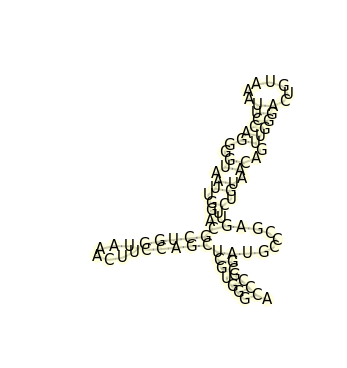

82


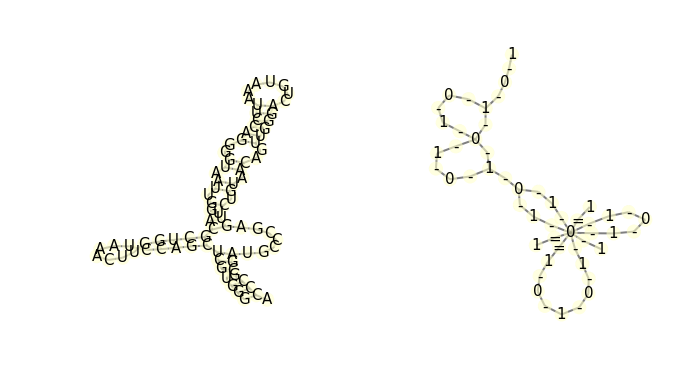

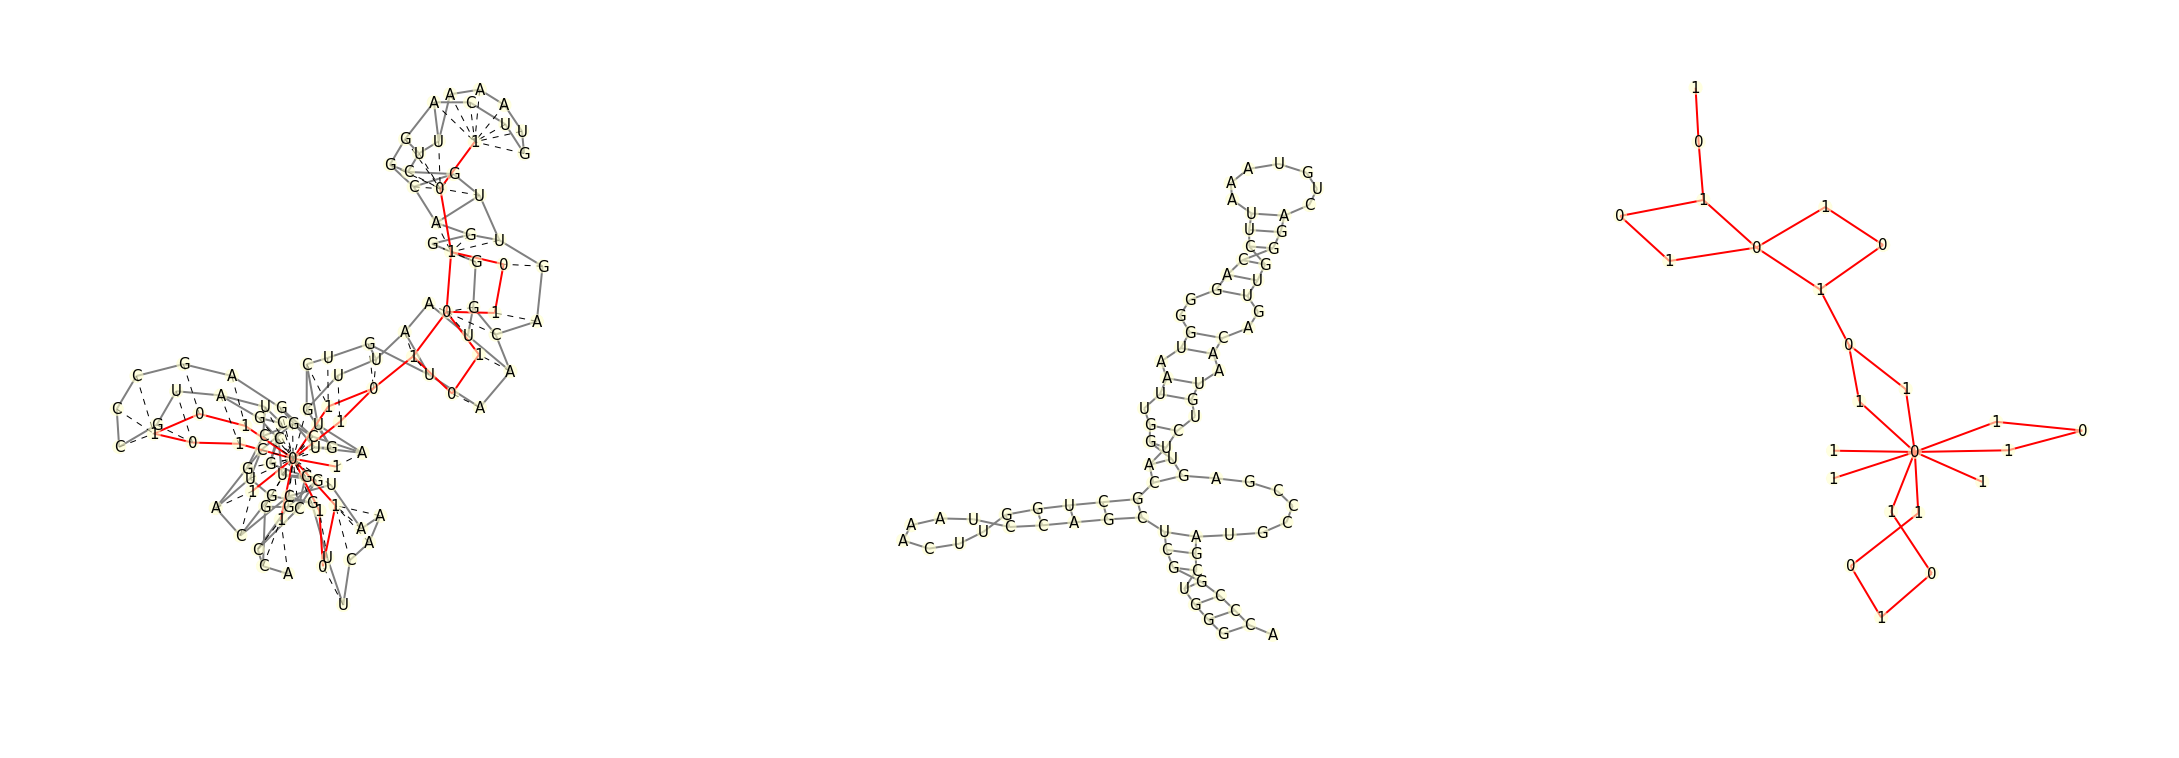

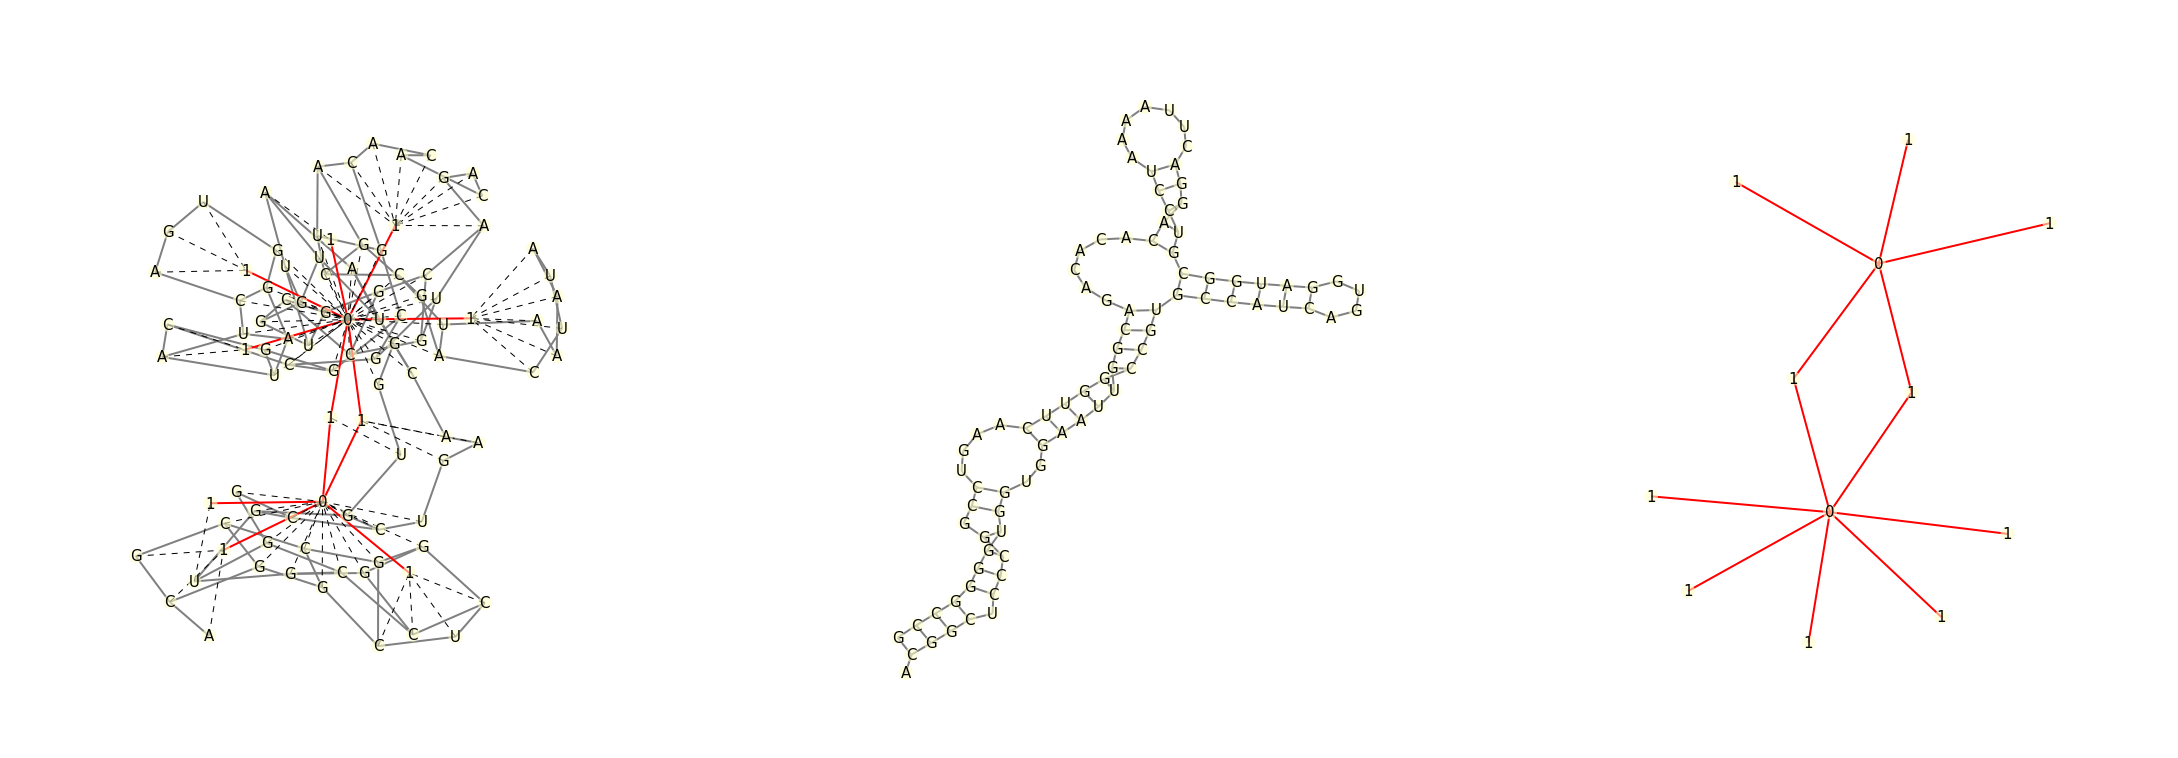

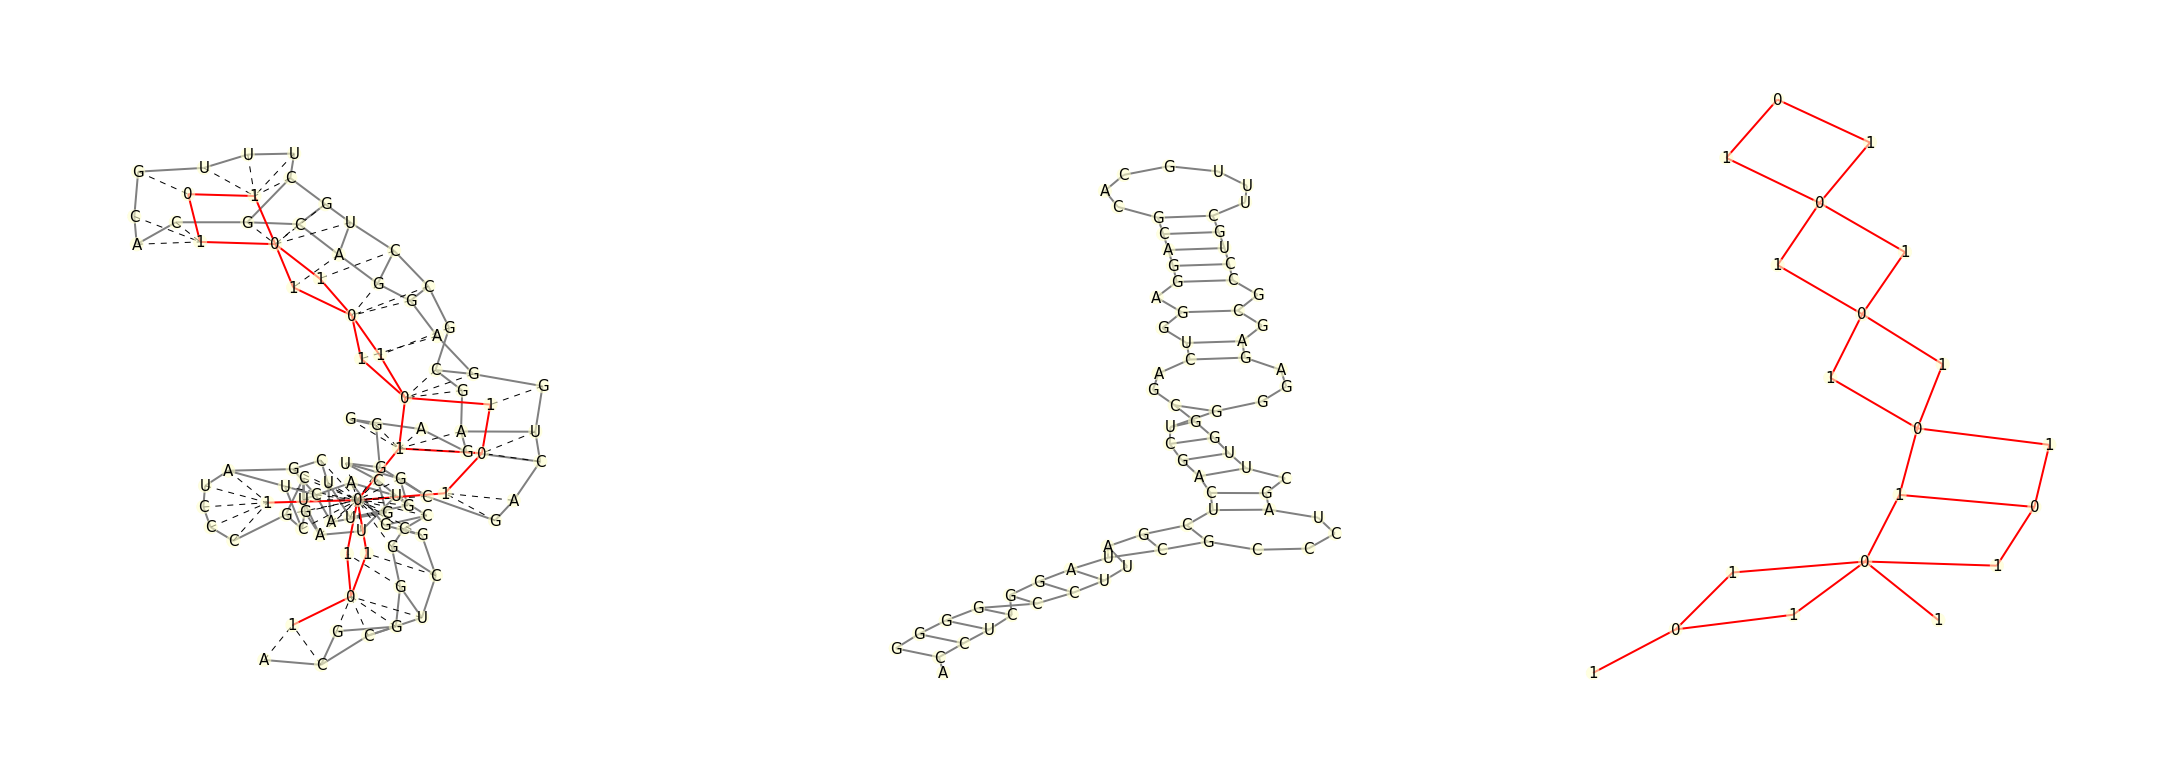

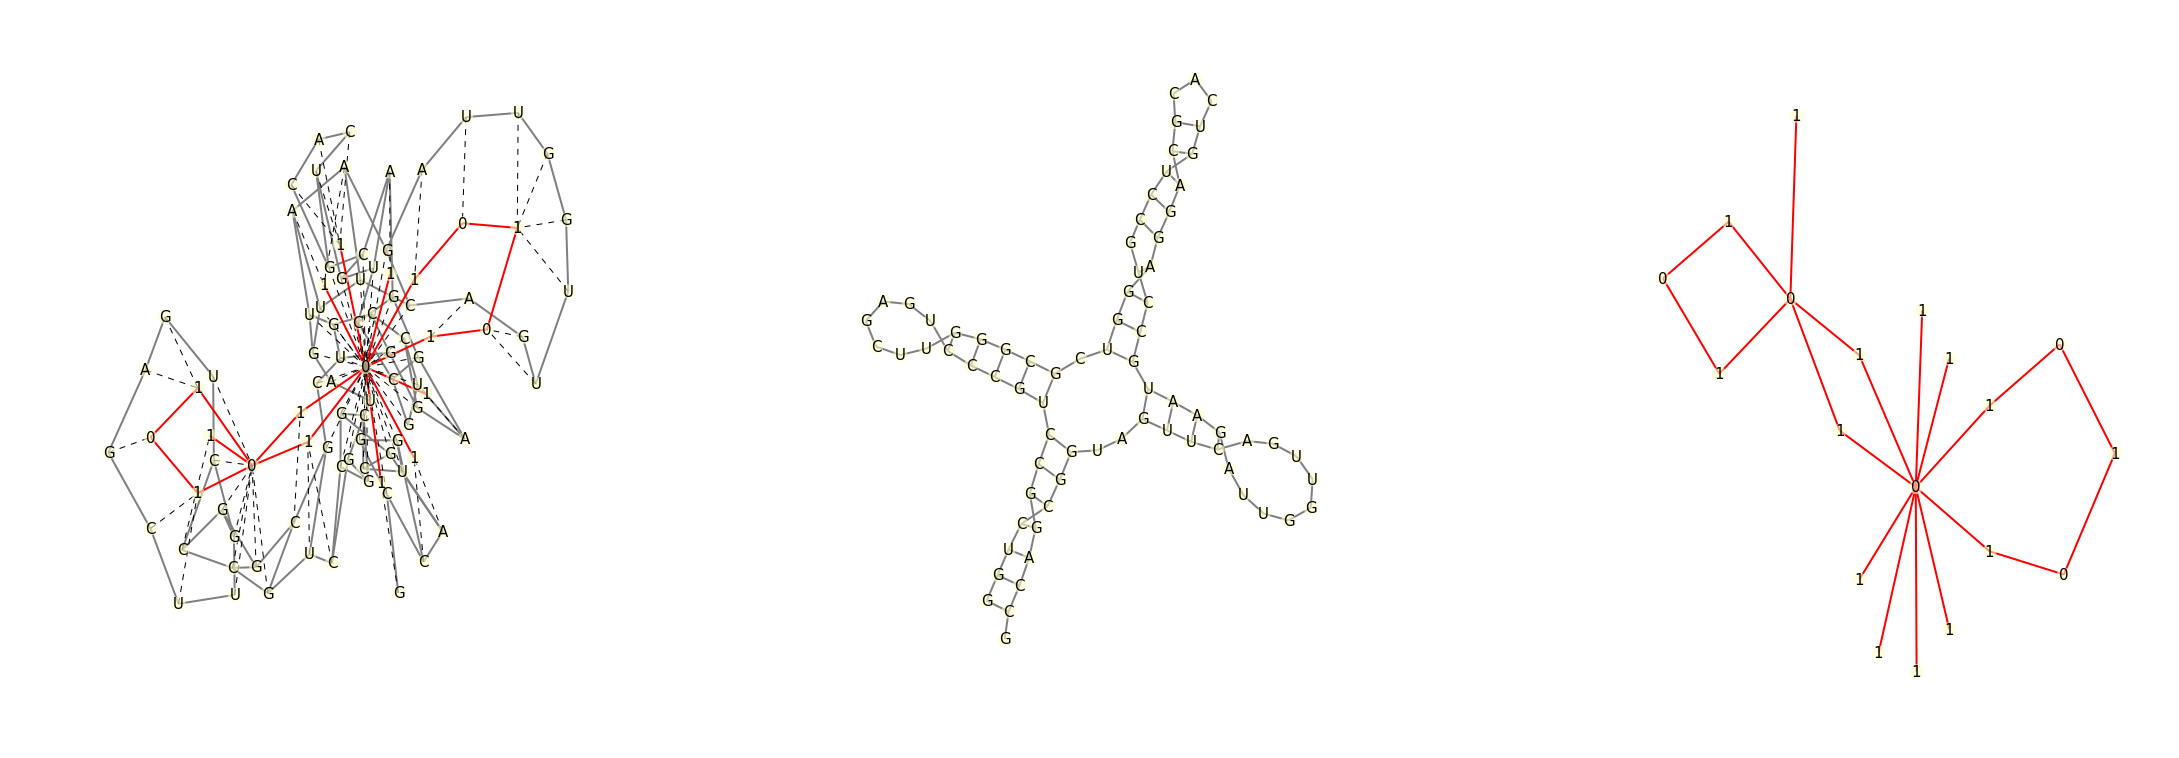

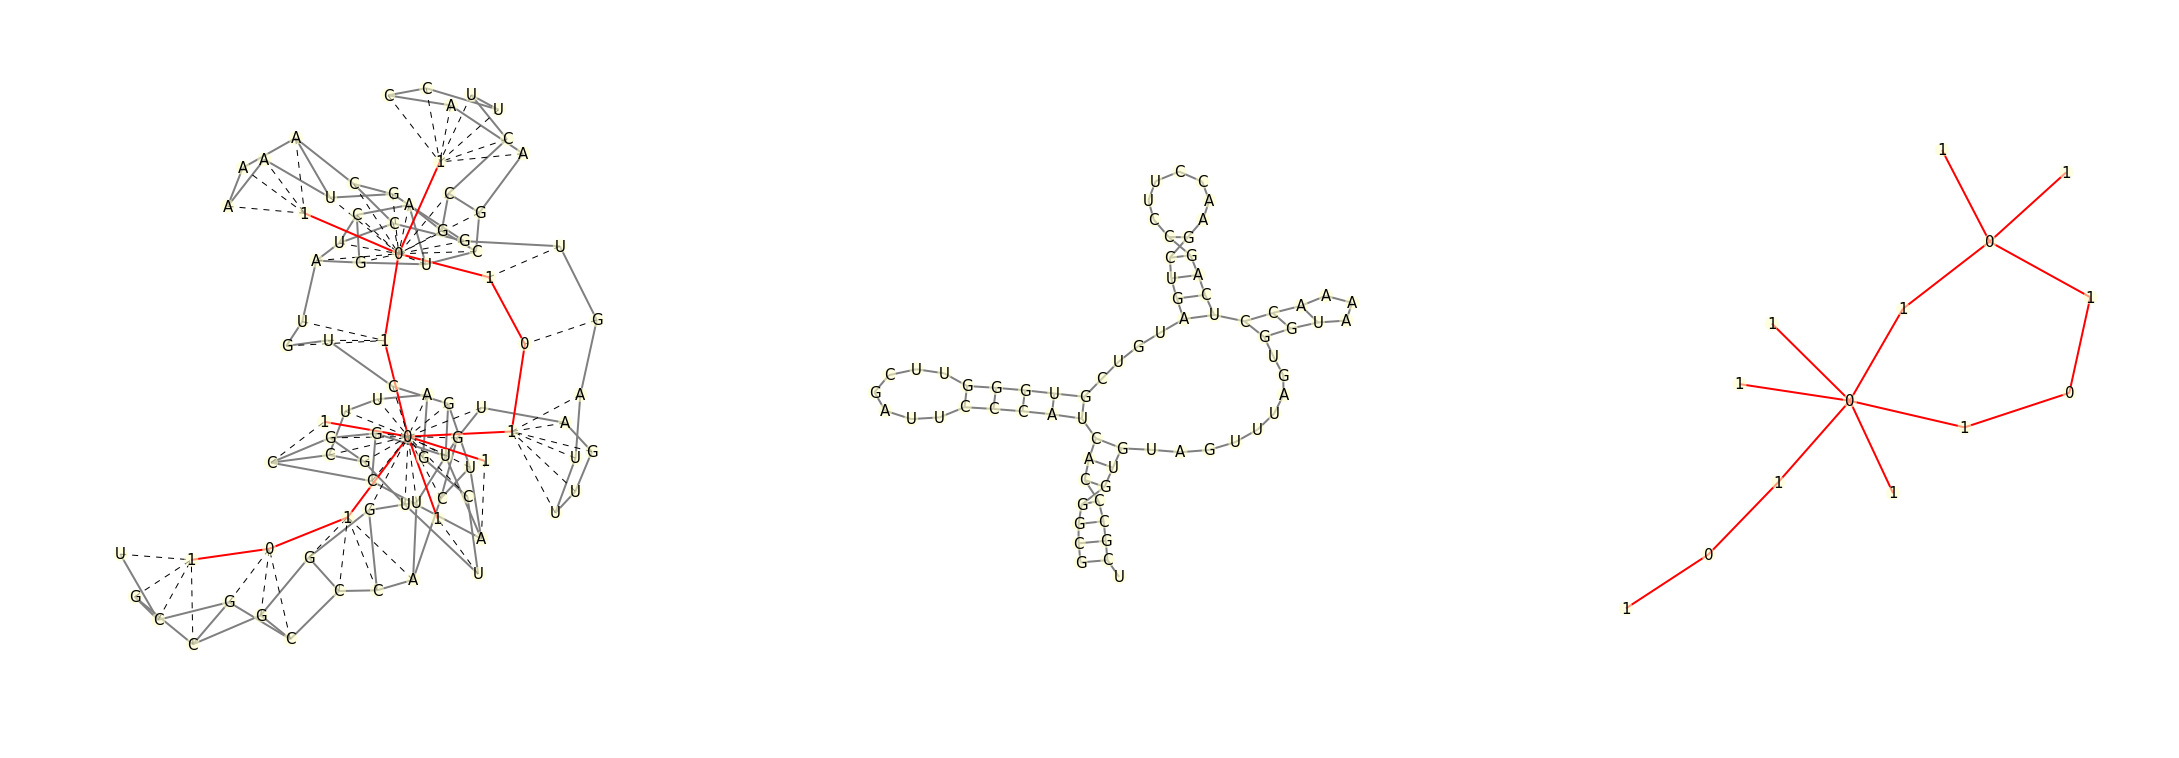

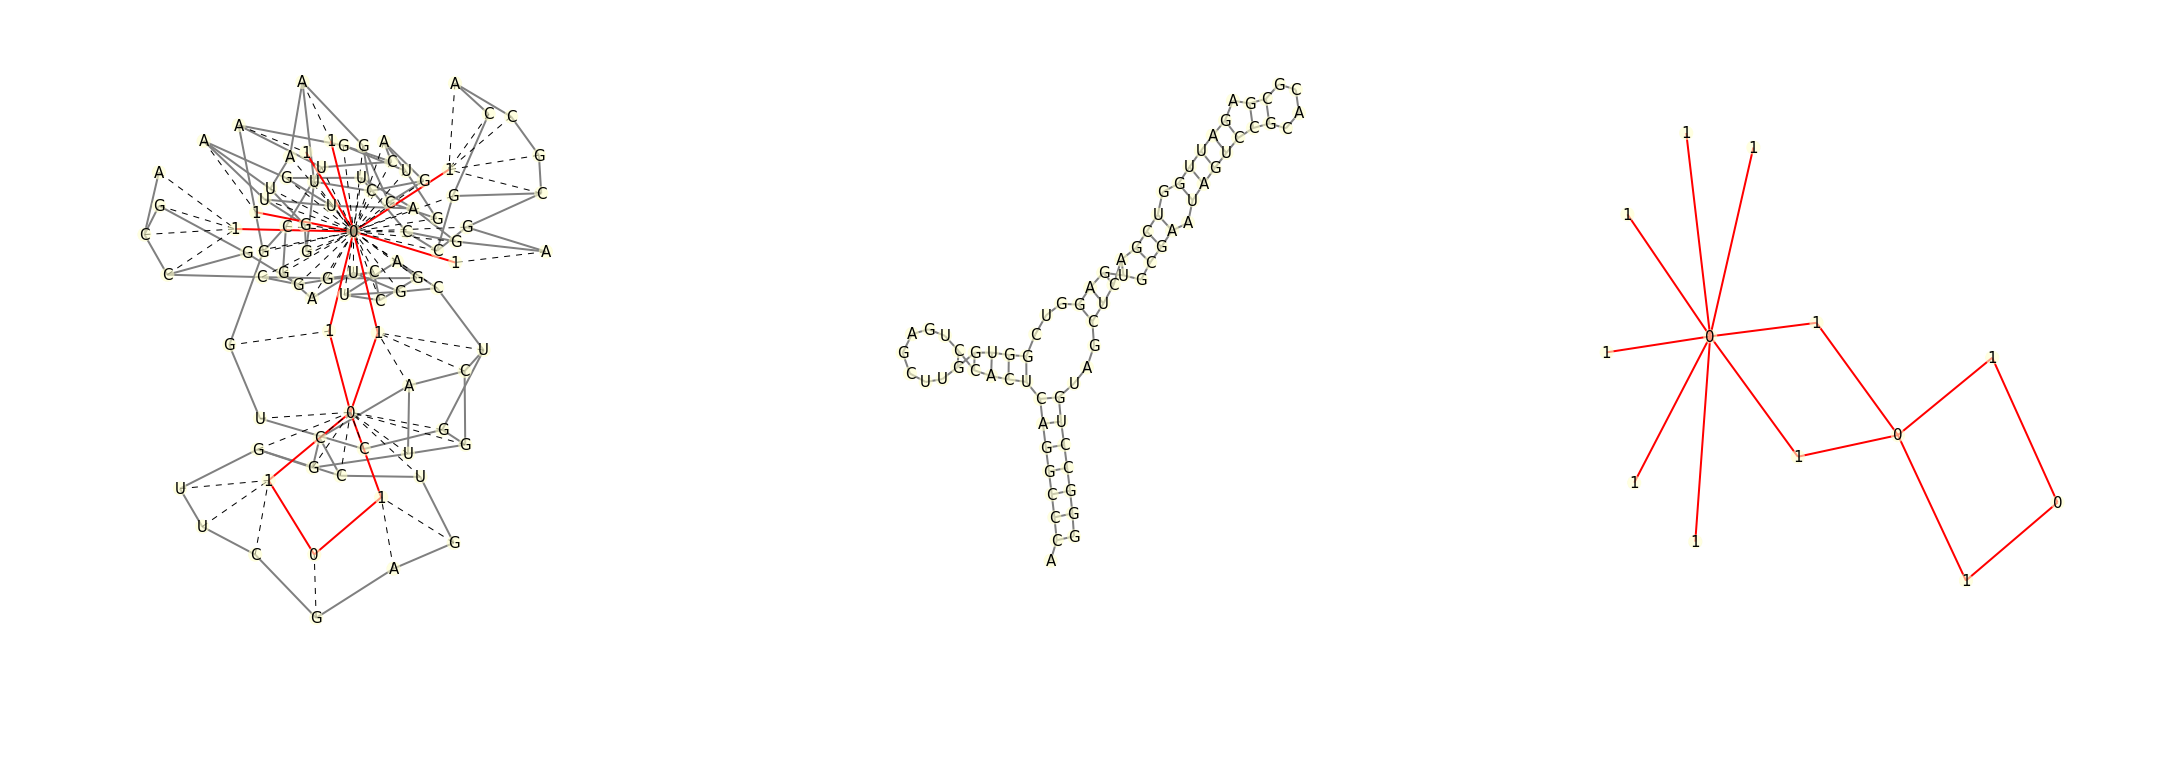

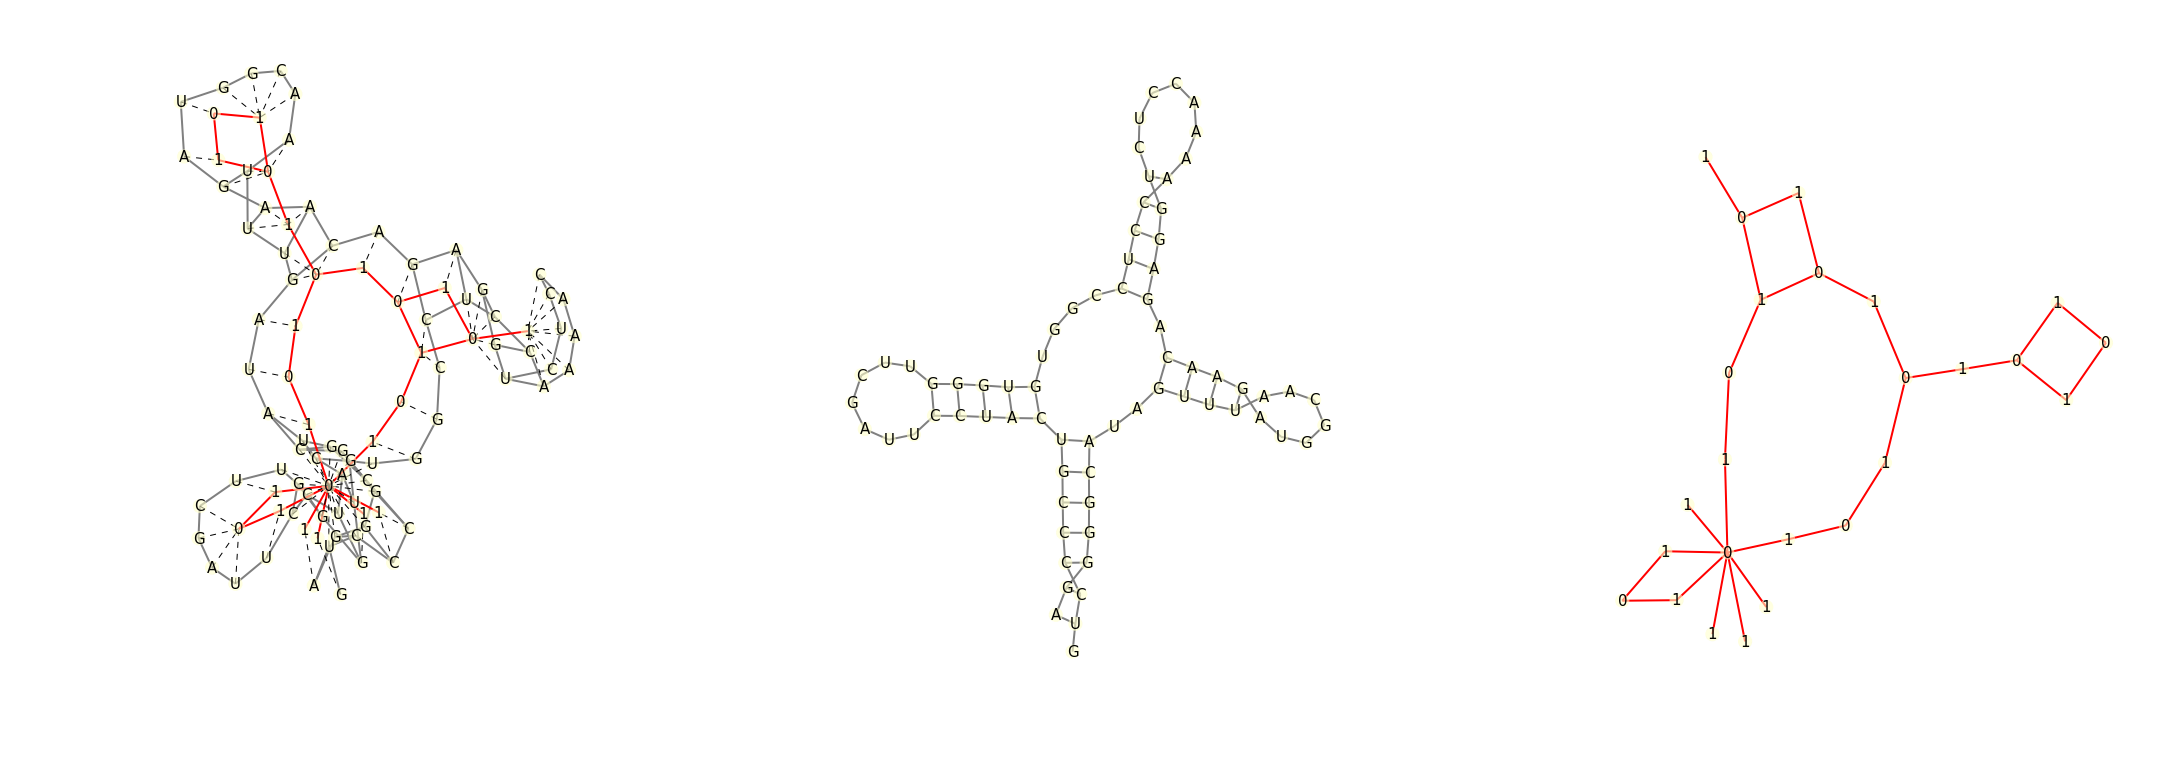

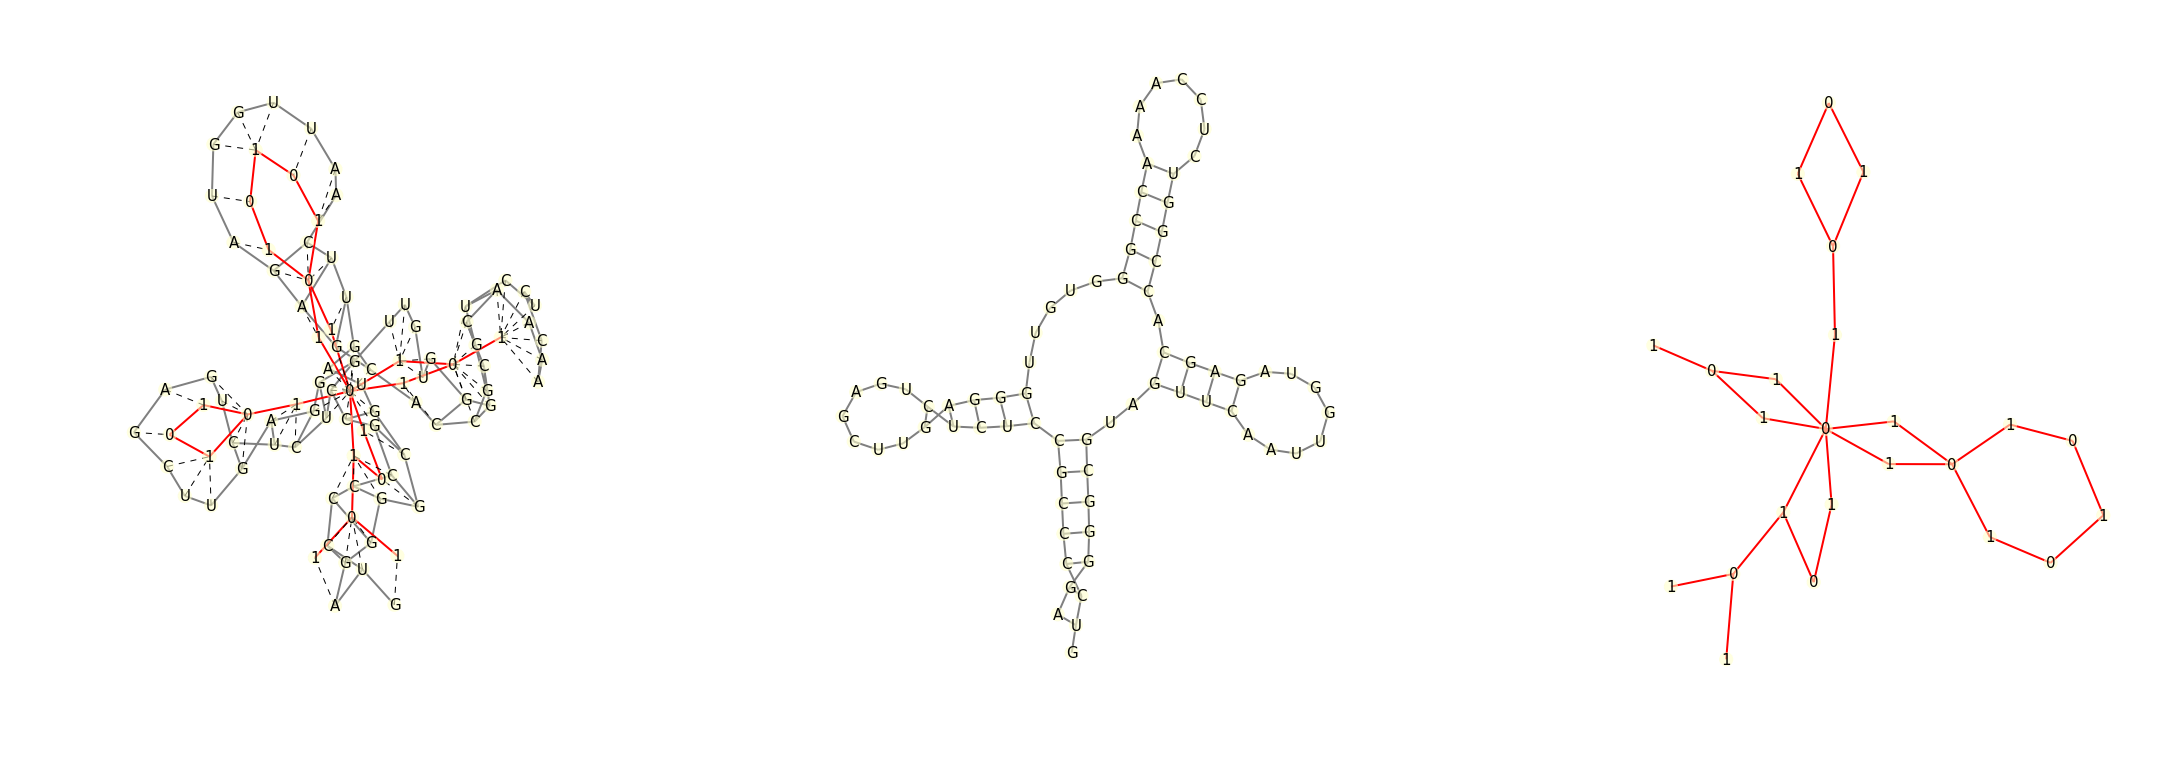

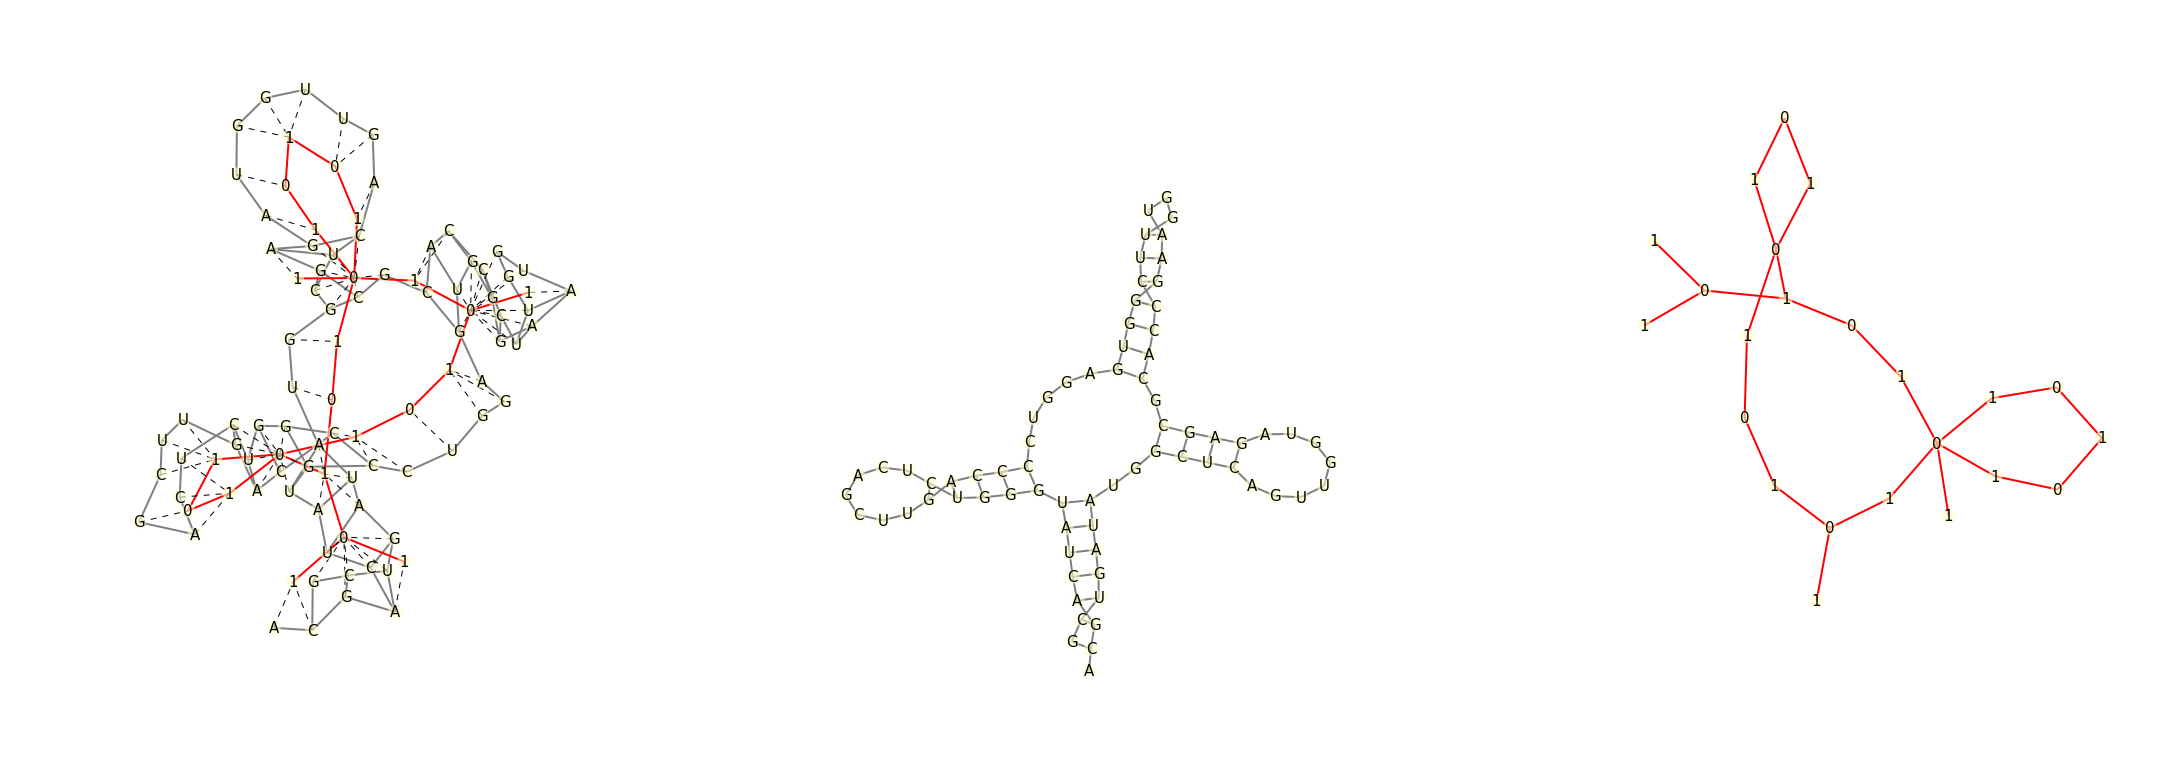

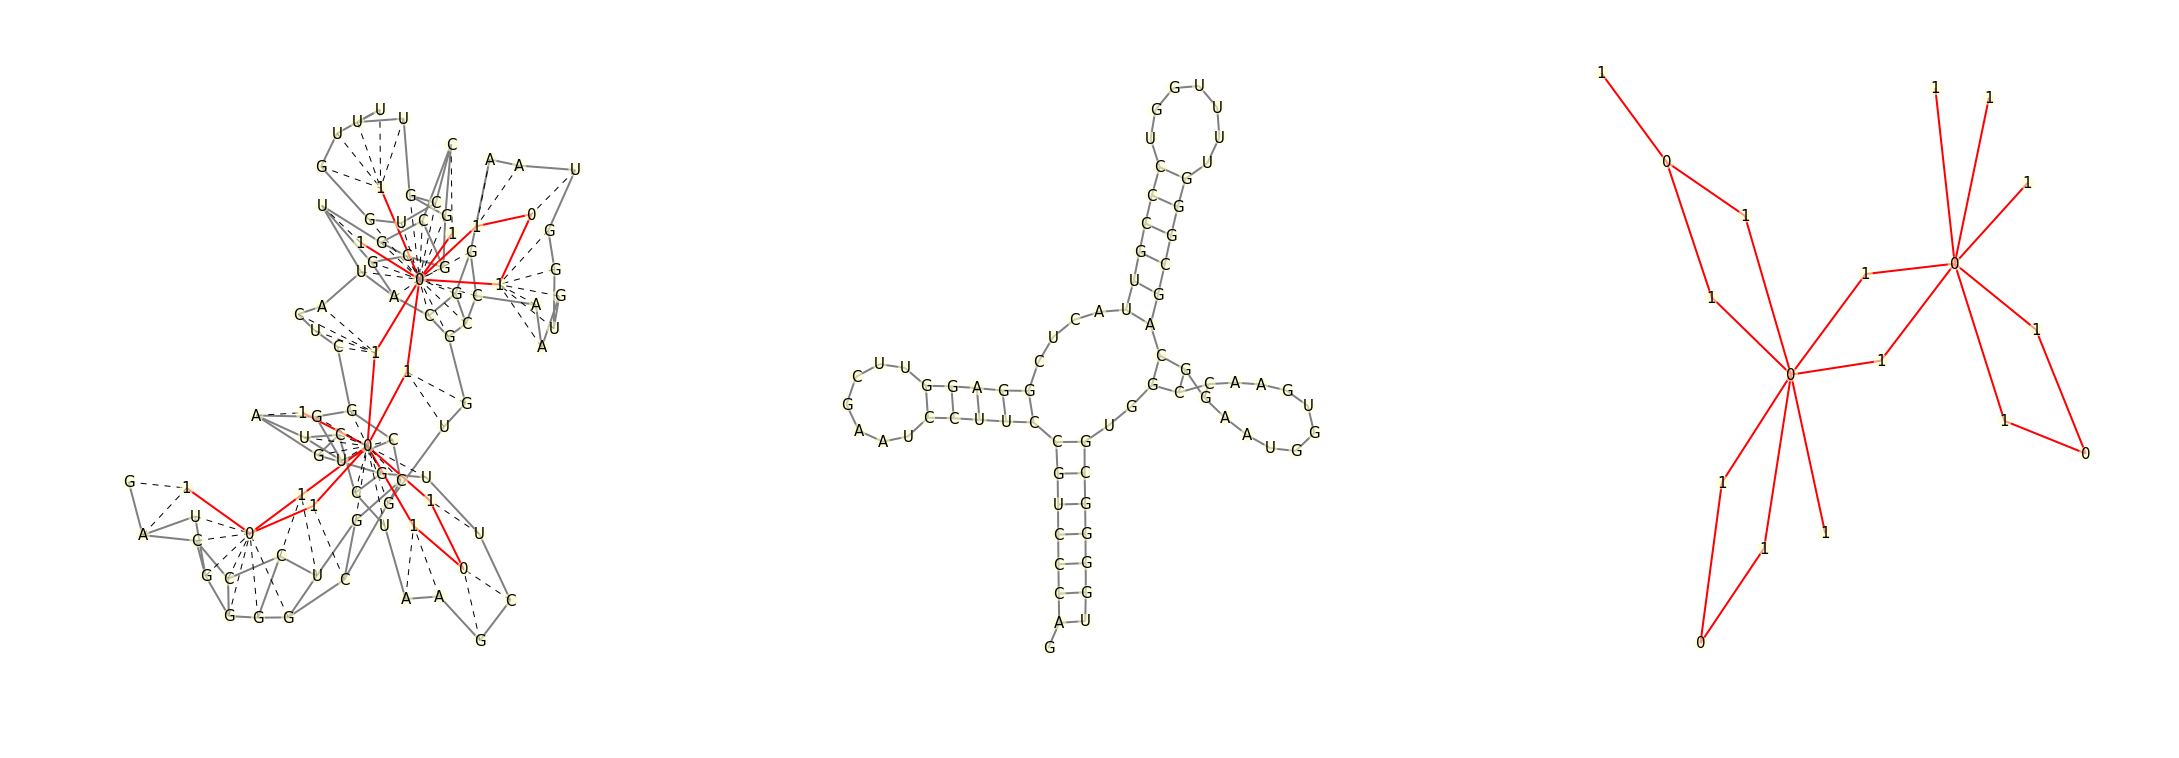

In [12]:

from graphlearn.utils import draw
gr = [i for i in get_graphs(size=10)]
pp.re_transform_single(gr[5])
for i in range(10):
    draw.graphlearn([gm[i+5].graph(),gm[i+5].base_graph(),gm[i+5].abstract_graph()],size=13,contract=True, abstract_color='red')


In [22]:
%%time
'''
learning a grammar
'''
import graphlearn.abstract_graphs.score_based as sb
from graphlearn.graphlearn import GraphLearnSampler as GLS
graphs = get_graphs(size=100)
sampler=GLS(radius_list=[0,1],thickness_list=[1], min_cip_count=2, min_interface_count=2, preprocessor=sb.PreProcessor(base_thickness_list=[2],kmeans_clusters=2))

sampler.fit(graphs,n_jobs=1,batch_size=1)

sampler.save('tmp/rna_annotate.ge')




fitting was asked with n=1

Classifier:
SGDClassifier(alpha=0.000173901038291, average=False, class_weight=None,
       epsilon=0.1, eta0=0.176355431649, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='log', n_iter=45, n_jobs=1,
       penalty='l2', power_t=0.249715930344, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

Predictive performance:
            accuracy: 1.000 +- 0.000
           precision: 1.000 +- 0.000
              recall: 1.000 +- 0.000
                  f1: 1.000 +- 0.000
   average_precision: 1.000 +- 0.000
             roc_auc: 1.000 +- 0.000
#instances: 100  #interfaces: 39   #cores: 42   #core-interface-pairs: 117
Saved model: tmp/rna_annotate.ge
CPU times: user 3min, sys: 8.08 s, total: 3min 8s
Wall time: 4min 5s


interface id: 796858 [8 options]


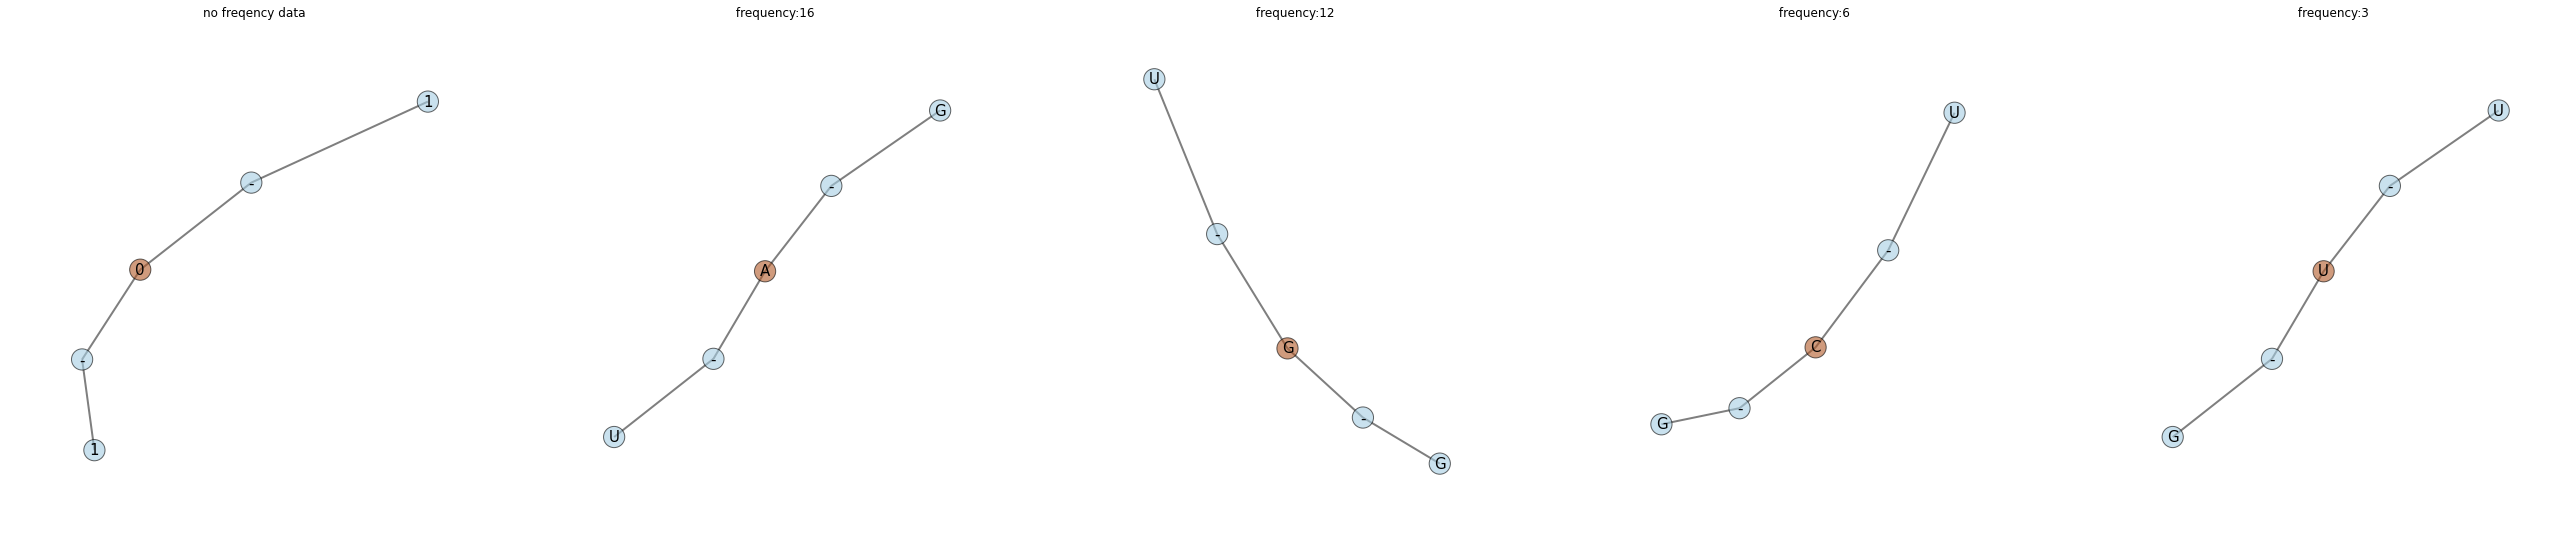

interface id: 662939 [8 options]


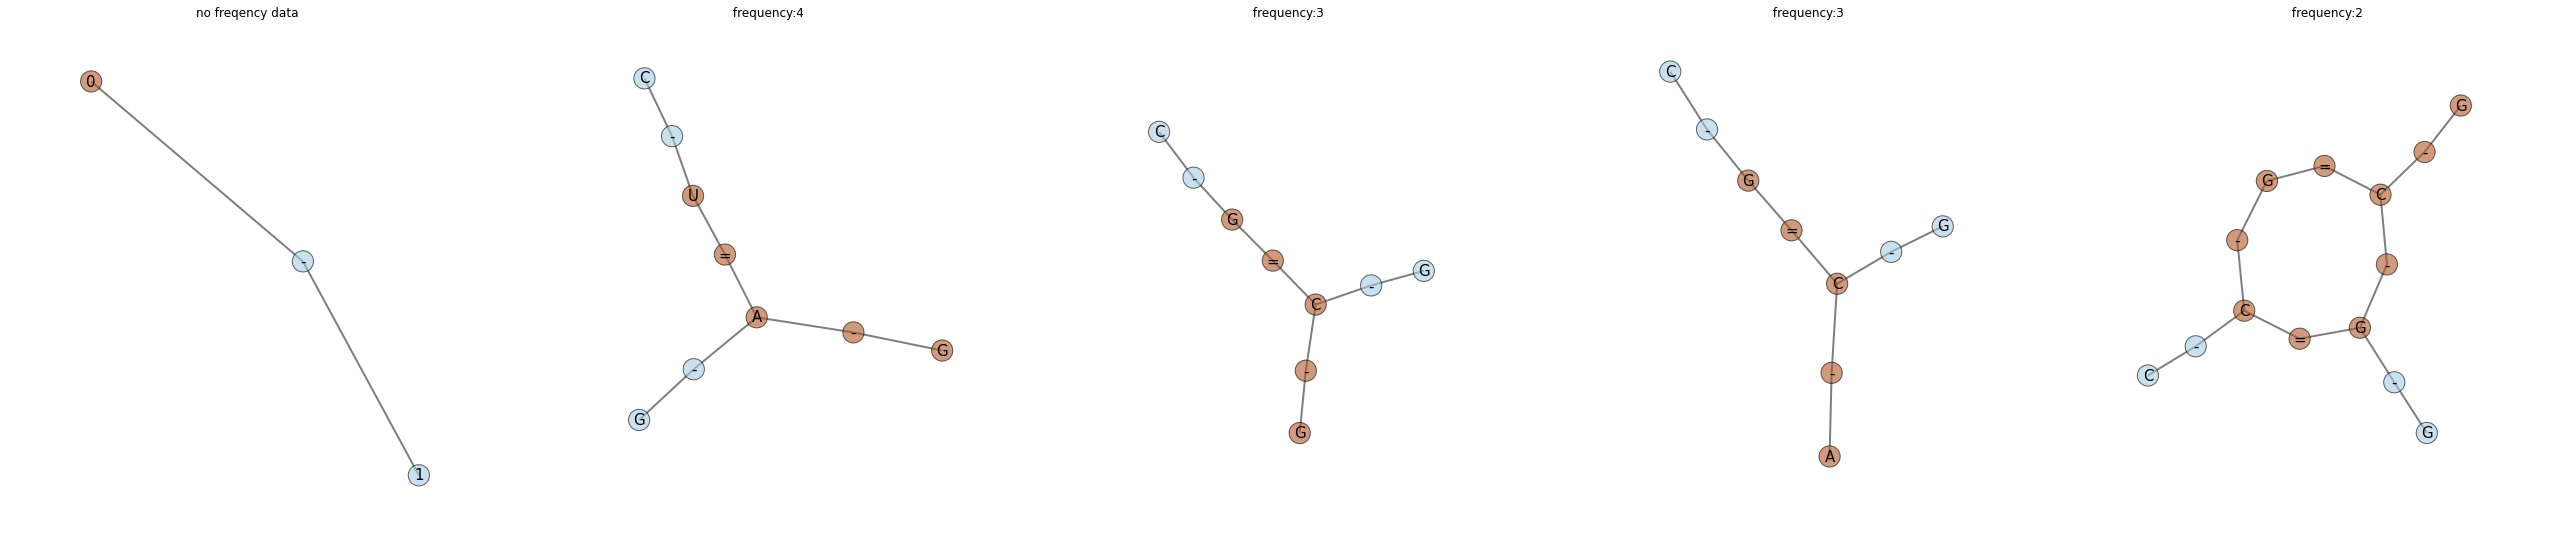

interface id: 847191 [6 options]


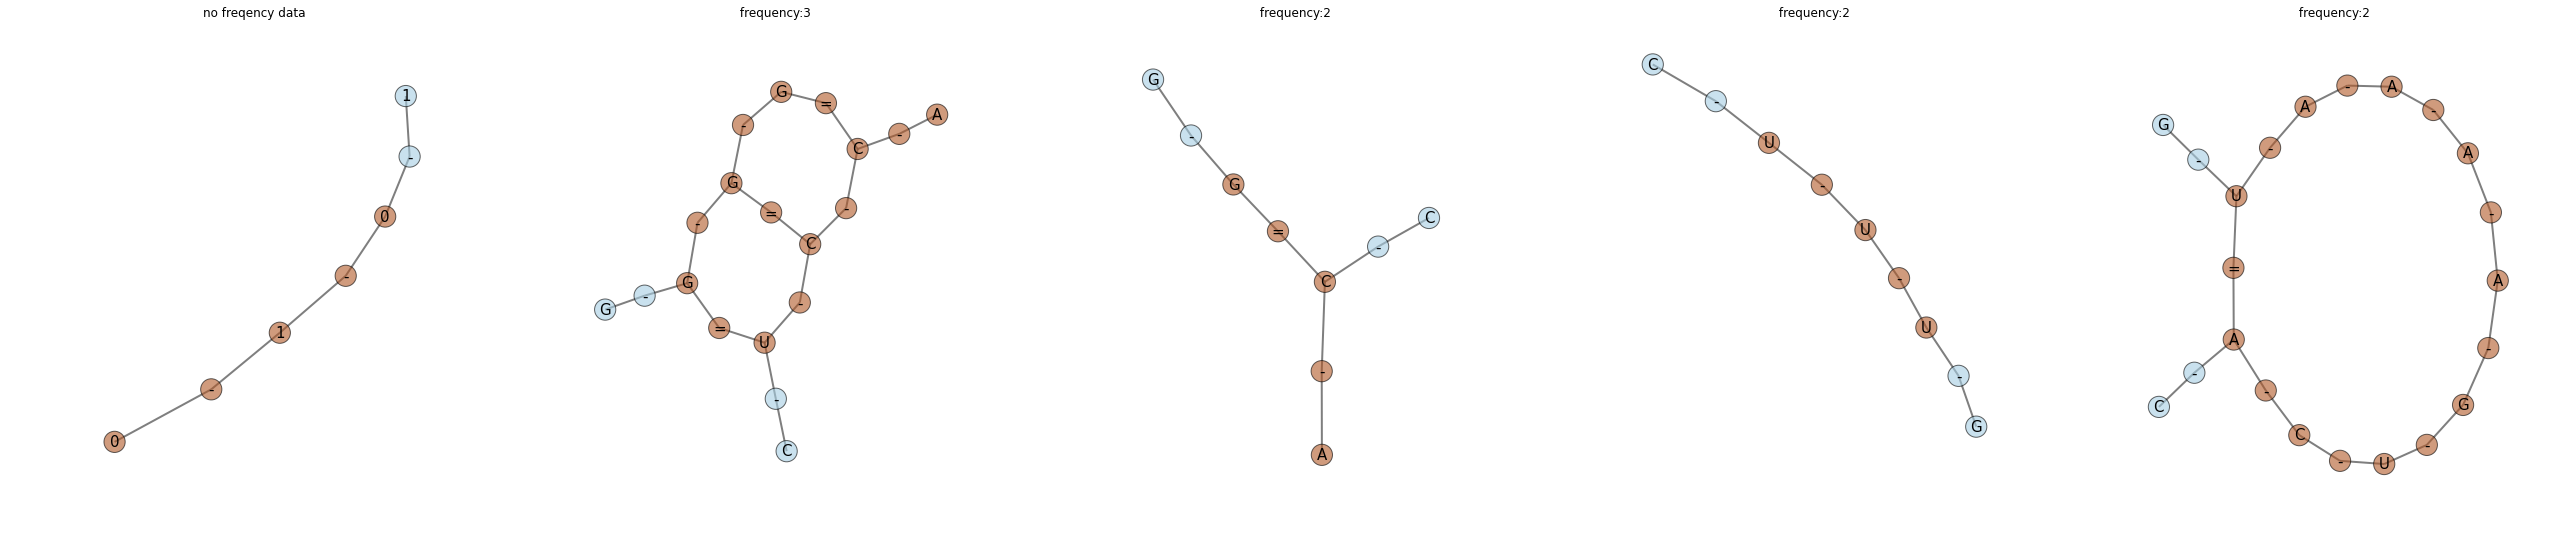

interface id: 470650 [6 options]


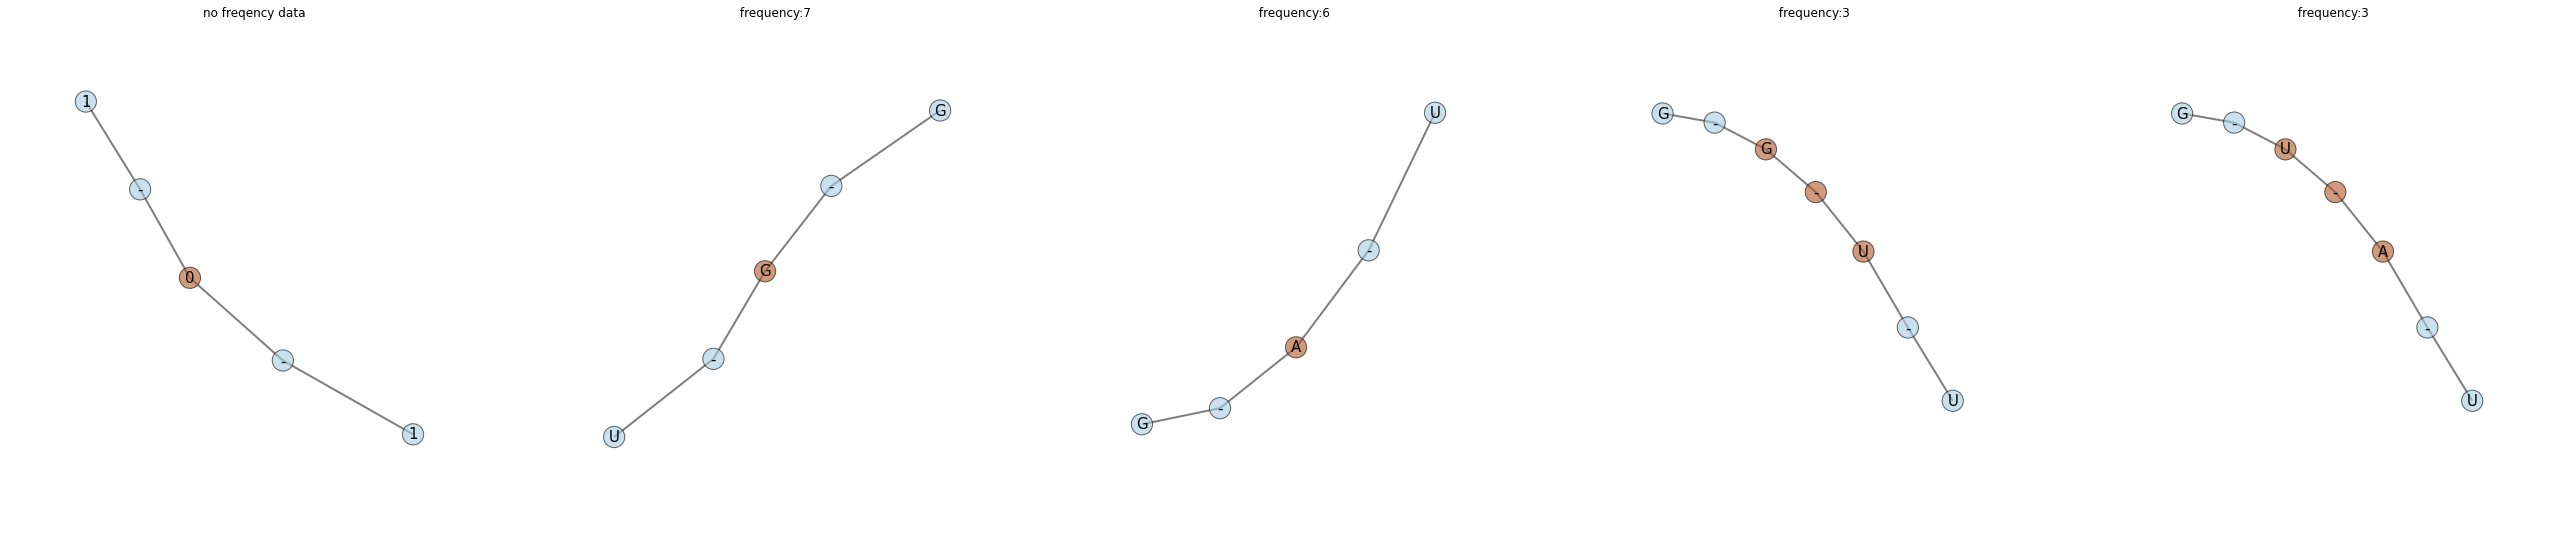

interface id: 376250 [5 options]


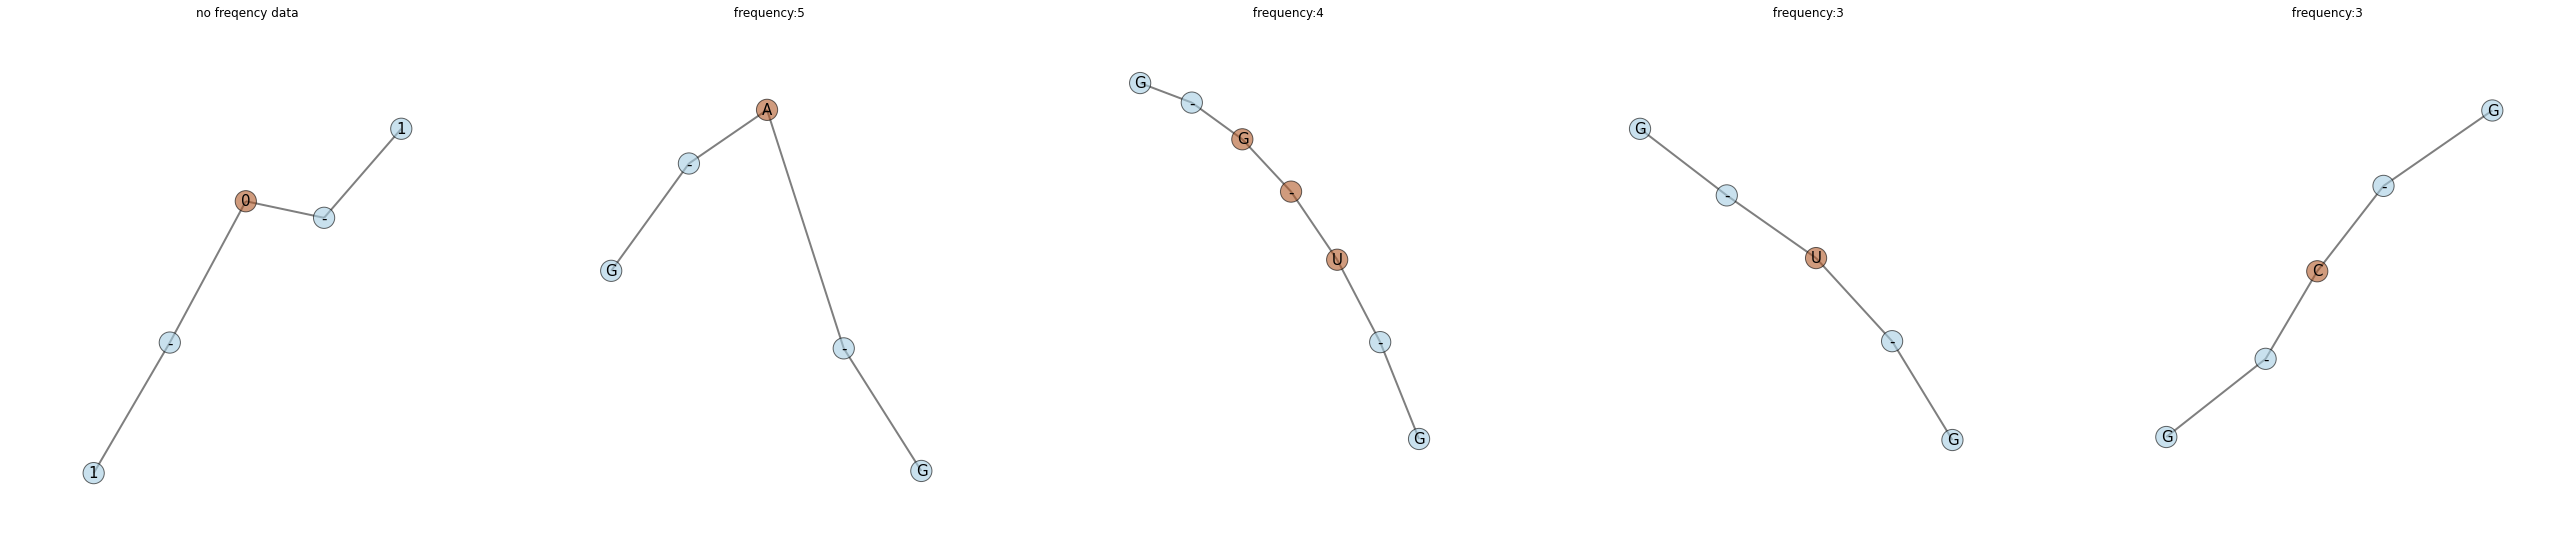

In [23]:
#draw production rules
draw.draw_grammar(sampler.lsgg.productions,n_productions=5,n_graphs_per_production=5,
                     n_graphs_per_line=5, size=9, contract=False,
                     colormap='Paired', invert_colormap=False,node_border=1,
                     vertex_alpha=0.6, edge_alpha=0.5, node_size=450, abstract_interface=True)

    

preprocessing grammar
_sample_notes: None
accept_static_penalty: 0.0
batch_size: 1
    burnin: 0
estimatorobject: <graphlearn.estimator.Wrapper instance at 0x7f59225323b0>
feasibility_checker: <graphlearn.feasibility.FeasibilityChecker instance at 0x7f59225323f8>
generator_mode: False
hash_bitmask: 1048575
improving_linear_start: 0
improving_penalty_per_step: 0.02
improving_threshold: 50
keep_duplicates: True
      lsgg: <graphlearn.localsubstitutablegraphgrammar.LocalSubstitutableGraphGrammar object at 0x7f590d0925d0>
max_core_size_diff: -2
    n_jobs: 1
   n_steps: 100
      nbit: 20
node_entity_check: <function <lambda> at 0x7f5922539aa0>
 omit_seed: False
postprocessor: <graphlearn.processing.PostProcessor object at 0x7f592253a310>
preprocessor: <graphlearn.abstract_graphs.score_based.PreProcessor object at 0x7f590d092450>
probabilistic_core_choice: False
proposal_probability: False
quick_skip_orig_cip: True
radius_list: [0, 2]
random_state: None
sample_path: None
sampling_interval

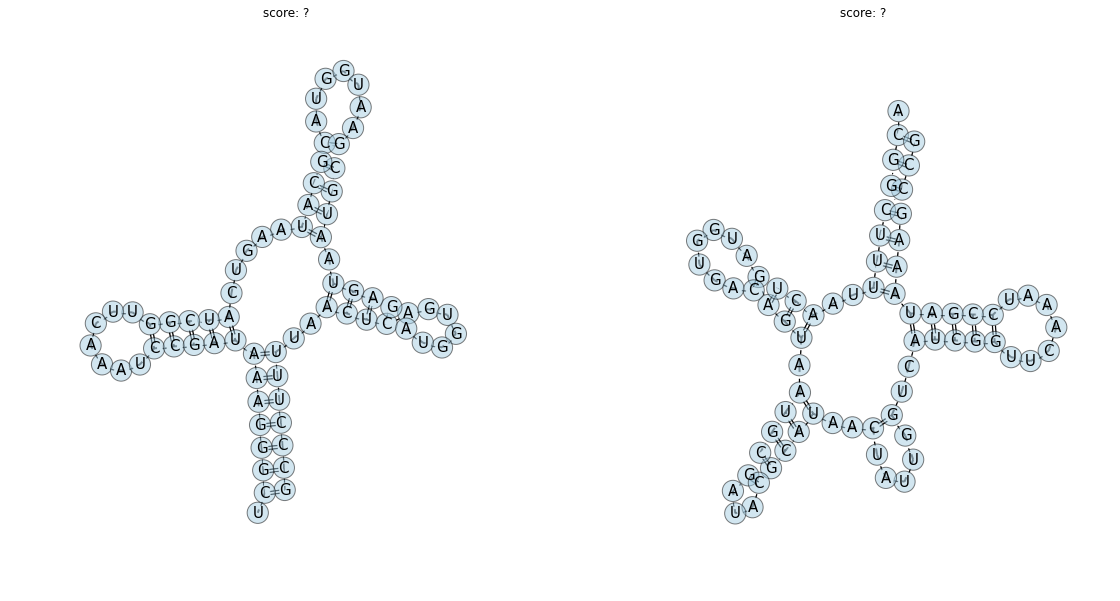

KeyboardInterrupt: 

In [24]:
%%time
'''
Molecule sampling
'''
import os
os.nice(19)
import graphlearn.utils.draw as draw
import graphlearn.abstract_graphs.molecules as mole
import itertools
#sampler=mole.MolecularSampler()
#sampler.load('tmp/mole_ubergrammar.ge')
graphs = get_graphs()

id_start=15
id_end=id_start+9
graphs = itertools.islice(graphs,id_start,id_end)
n_steps=100

graphs = sampler.sample(graphs,
                        n_samples=5,
                        batch_size=1,
                        n_steps=n_steps,
                        n_jobs=1,
                        quick_skip_orig_cip=True,
                        probabilistic_core_choice=False,
                        burnin=0,
                        improving_threshold=0.5,
                        max_core_size_diff=-1,
                        select_cip_max_tries=100,
                        keep_duplicates=True,
                        omit_seed=False)

 
scores=[]
ids=range(id_start,id_end)
for i,graph in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(graph.graph['sampling_info']['score_history'])
    path_graphs = graph.graph['sampling_info']['graphs_history']
    

    path_graphs= list(path_graphs)
    draw.graphlearn(path_graphs,
                           n_graphs_per_line=5, size=10, 
                           colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                           vertex_alpha=0.5, edge_alpha=0.7, node_size=450,edge_label='label',
                          headlinehook= draw.get_score_of_graph
                          )
    

In [ ]:
%matplotlib inline
from itertools import islice
import numpy as np
import matplotlib.pyplot as plt
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()

In [ ]:
import graphlearn.abstract_graphs.molecules as mole
from graphlearn.utils import draw
from eden.graph import Vectorizer
v=Vectorizer()
from graphlearn.abstract_graphs.molecules import node_to_cycle
import networkx as nx
import eden

def make_abstract(graph):
    '''
    make sure this is not expanded
    '''
    # prepare fast hash function
    def fhash(stuff):
        return eden.fast_hash(stuff, 2 ** 20 - 1)
    
    
    # all nodes get their cycle calculated
    for n, d in graph.nodes(data=True):
        d['cycle'] = list(node_to_cycle(graph, n))
        d['cycle'].sort()
        #if 'parent'in d:
        #    d.pop('parent')
            

    
    # make sure most of the abstract nodes are created.
    abstract_graph = nx.Graph()
    for n, d in graph.nodes(data=True):
        cyclash = fhash(d['cycle'])
        if cyclash not in abstract_graph.node:
            abstract_graph.add_node(cyclash)
            abstract_graph.node[cyclash]['contracted'] = set(d['cycle'])
            abstract_graph.node[cyclash]['node'] = True
            # it is possible that a node belongs to more than 1 cycle, so...
            # each node gets parents
            for e in d['cycle']:
                node = graph.node[e]
                if 'parent' not in node:
                    node['parent'] = set()
                node['parent'].add(cyclash)


    
    #  HERE THE ACTUAL ABSTRACTION BEGINS

    # connect nodes in the abstract graph
    get_element = lambda x: list(x)[0]


    
    # FOR ALL ABSTRACT NODES
    for n, d in abstract_graph.nodes(data=True):
        # FIND A LABEL
        if len(d['contracted']) > 1:
            labels = [ord(graph.node[childid]['label']) for childid in d['contracted']]
            labels.sort()
            d['label'] = "cycle" #fhash(labels)

        else:
            d['label'] = graph.node[get_element(d['contracted'])]['label']

      
 
        # THEN LOOK AT ALL CONTRACTED NODES TO FIND OUT WHAT CONNECTION WE HAVE TO OUR NEIGHBORS
        for base_node in d['contracted']:
            base_neighbors = graph.neighbors(base_node)
            # for all the neighbors
            for neigh in base_neighbors:
                
                
                # find out if we have to build a connector node
                if len(graph.node[neigh]['cycle']) > 1 and len(d['contracted']) > 1:

                    for other in graph.node[neigh]['parent']:
                        if other != n:
                            l = [other, n]
                            l.sort()
                            connector = fhash(l)
                            
                            
                            shared_nodes = abstract_graph.node[other]['contracted'] & d['contracted']
                            if len(shared_nodes)==0:
                                label='e'
                            else:
                                labels = [ord(graph.node[sid]['label']) for sid in shared_nodes]
                                labels.sort()
                                share_hash = fhash(labels)
                                label='share:'+str(share_hash)
                            abstract_graph.add_edge(other,n,label=label)
                            '''
                            if connector not in abstract_graph.node:
                                # we need to consider making the edge the actual intersect of the two...

                                abstract_graph.add_node(connector)
                                abstract_graph.node[connector]['edge'] = True

                                # abstract_graph.node[connector]['label']='edge'
                                shared_nodes = abstract_graph.node[other]['contracted'] & d['contracted']
                                labels = [ord(graph.node[sid]['label']) for sid in shared_nodes]
                                labels.sort()
                                share_hash = fhash(labels)


                                abstract_graph.node[connector]['label'] = "shared" + str(share_hash)

                                abstract_graph.add_edge(other, connector)
                                abstract_graph.add_edge(connector, n)
                            '''
                else:
                    for e in graph.node[neigh]['parent']:
                        abstract_graph.add_edge(n, e, label='e')
    return abstract_graph




def graphor(base,abstr,nested=True):
    g= nx.disjoint_union(base, abstr)
    node_id= len(g)

    for n,d in g.nodes(data=True):
        if 'contracted' in d and 'edge' not in d:
            for e in d['contracted']:
                if 'edge' not in g.node[e]:
                    # we want an edge from n to e
                    g.add_node(node_id,edge=True,label='e')
                    g.add_edge( n, node_id, nesting=True)
                    g.add_edge( node_id, e, nesting=True)
                    #g.add_edge( n, e, nesting=True)
                    node_id+=1
    return g
    


gr=get_graphs()
for i in range(1):
    g=gr.next()
    ab=make_abstract(g)
    
    g=v._edge_to_vertex_transform(g)
    ab=v._edge_to_vertex_transform(ab)
    zz=graphor(g,ab)
    draw.graphlearn([g,ab], size=20)
    v.transform_single(zz)

    
